# Chapter 5.3: The Freshman Plague III

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [2]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap05 import *

import pandas as pd

In [3]:
# Create a system
tc = 3             # time between contacts in days 
tr = 4             # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

## Hand washing

Suppose you are the Dean of Student Life, and you have a budget of just \$1200 to combat the Freshman Plague. You have two options for spending this money:

1.  You can pay for vaccinations, at a rate of \$100 per dose.

2.  You can spend money on a campaign to remind students to wash hands
    frequently.

We have already seen how we can model the effect of vaccination. Now
let's think about the hand-washing campaign. We'll have to answer two
questions:

1.  How should we incorporate the effect of hand washing in the model?

2.  How should we quantify the effect of the money we spend on a
    hand-washing campaign?

For the sake of simplicity, let's assume that we have data from a
similar campaign at another school showing that a well-funded campaign
can change student behavior enough to reduce the infection rate by 20%.

In terms of the model, hand washing has the effect of reducing `beta`: because students are less likely to infect others, then we assume there are fewer contacts between students that could result in infection.
That's not the only way we could incorporate the effect, but it seems
reasonable and it's easy to implement.

Now we have to model the relationship between the money we spend and the
effectiveness of the campaign. Again, let's suppose we have data from
another school that suggests:

-   If we spend \$500 on posters, materials, and staff time, we can
    change student behavior in a way that decreases the effective value of `beta` by 10%.

-   If we spend \$1000, the total decrease in `beta` is almost 20%.

-   Above \$1000, additional spending has little additional benefit.

## Choosing a function to model benefits of hand-washing

We have made an assumption that spending more money on a hand-washing campaign will decrease `beta`.   But we need to define that relationship: how much does each new dollar spent change the parameter?

As with other modeling decisions, this one requires that we make some assumptions (see the assumptions in the previous cell, for instance).  Our function just quantizes these assumptions.   We could assume a linear function: each dollar increases `beta` by a given amount, until we reach 1000 dollars.  This function would look like this, where `D` is the number of dollars spent and $\Delta \beta$ is the change in `beta`:

$$If D < 1000, \Delta \beta  (D) = (0.20D)/1000$$

$$ If D  >= 1000, \Delta \beta  (D) = 0.20$$

But let's use a model that fits our intuition better.   Let's assume that spending a couple dollars would have little benefit: that is, benefits wouldn't really occur until you spent at least a couple hundred dollars.  And further, let's assume that the benefit would gradually decrease as spending approached \$1000.

One possible function that fits this description is a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

Here's a python function that creates a logistic curve:

In [4]:
from numpy import exp

def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

Now we need a function that creates the particular logistic function that we want.  We can choose the parameters to fit our assumptions about the effects of spending money on hand-washing: 

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20\%.

`B` is chosen by trial and error to yield a curve that seems feasible.

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.  It will return a `beta` reduction from 0\% to 20\% based upon the level of spending:

In [5]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Let's see what our curve looks like.  We create a `linspace` of possible spending amounts from 0 to 1200 dollars, convert our array to a percent, and then plot it:

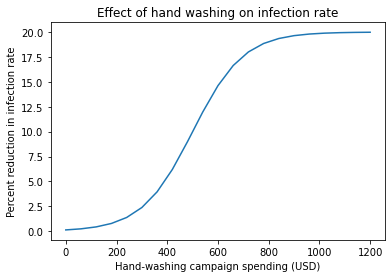

In [7]:
spending = linspace(0, 1200, 21)

percent_reduction = compute_factor(spending) * 100

spend_vs_reduce = pd.Series(data=percent_reduction,index=spending)

spend_vs_reduce.plot(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate');

Now we need to use `compute_factor` to change the `beta` for a particular simulation.

`add_hand_washing` takes a
systems object and a budget, and modifies `system['beta']` to model the
effect of hand washing:

In [8]:
def add_hand_washing(system, spending):
    factor = compute_factor(spending)
    system['beta'] *= (1 - factor)

Now we can sweep a range of values for `spending` and use the simulation
to compute the effect:

In [11]:
def sweep_hand_washing(spending_array):
    sweep = pd.Series([],dtype=object)
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, change_func)
        sweep[spending] = calc_total_infected(results, system)
        
    return sweep

In [12]:
from numpy import linspace

# Create the spending range through which we'll sweep
spending_array = linspace(0, 1200, 20)
# Calculate the percentage of total infected students for each spending value
infected_sweep2 = sweep_hand_washing(spending_array)

The following figure shows the result. 

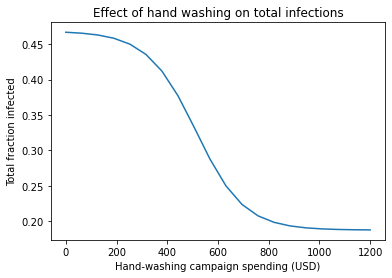

In [14]:
infected_sweep2.plot(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections');

Below \$200, the campaign has little effect. 

At \$800 it has a substantial effect, reducing total infections from more than 45% to about 20%. 

Above \$800, the additional benefit is small.

Not surprisingly, the results have a sigmoid shape: this is a direct result of the function we used to model the effects!

## Optimization

Let's put it all together. With a fixed budget of \$1200, we have to
decide how many doses of vaccine to buy and how much to spend on the
hand-washing campaign.

Here are the parameters:

In [15]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
max_doses

12

The fraction `budget/price_per_dose` might not be an integer. `int` is a
built-in function that converts numbers to integers, rounding down.

We'll sweep the range of possible doses:

In [19]:
dose_array = np.arange(0,max_doses+1,1)
dose_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Remember that `arange()` does not include the stop point (which here is 12): this is why we add 1 to `max_doses`.

Then we run the simulation for each element of `dose_array`:

In [23]:
def sweep_doses(dose_array):
    sweep = pd.Series([],dtype=object)
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        # Adjust system according to preventive actions
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        # Find results for each budget option
        results = run_simulation(system, change_func)
        sweep[doses] = calc_total_infected(results, system)

    return sweep

For each number of doses, we compute the fraction of students we can
immunize, `fraction` and the remaining budget we can spend on the
campaign, `spending`. Then we run the simulation with those quantities
and store the number of infections.

The following figure shows the result.

In [24]:
infected_sweep3 = sweep_doses(dose_array)

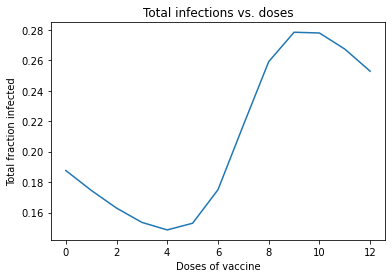

In [26]:
infected_sweep3.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses');

If we buy no doses of vaccine and spend the entire budget on the campaign, the fraction infected is around 19%. At 4 doses, we have \$800 left for the campaign, and this is the optimal point that minimizes the number of students who get sick.

As we increase the number of doses, we have to cut campaign spending,
which turns out to make things worse. But interestingly, when we get
above 10 doses, the effect of herd immunity starts to kick in, and the
number of sick students goes down again.

### Exercise 1

Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

<AxesSubplot:title={'center':'Total infections vs. doses'}, xlabel='Doses of vaccine', ylabel='Total fraction infected'>

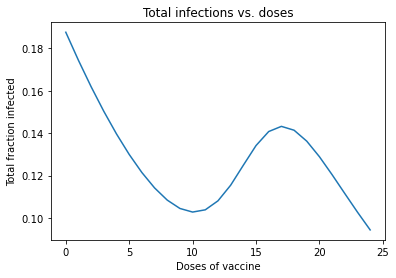

In [27]:
# Run and plot the simulation here
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
max_doses

dose_array = np.arange(0,max_doses+1,1)

infected_sweep3 = sweep_doses(dose_array)

infected_sweep3.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses')